# Дашборд для Яндекс.Дзен
Вы работаете аналитиком в Яндекс.Дзене. Почти всё ваше время занимает анализ пользовательского взаимодействия с карточками статей.\
Каждую неделю нужно предоставлять информацию по следующим вопросам:

    Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
    Как много карточек генерируют источники с разными темами?
    Как соотносятся темы карточек и темы источников?

**Цель работы:** создание дашборда для последуюшей автоматизации создания отчётов.

**Работа пройдёт в пять этапов:**

    Выполнение sql-запрос для получения нужного датасета.
    Изучение и проверка данных.
    Экспорт датасета как csv файла.
    Создание дашборда в Tableau.
    Создание краткой презентации.

In [1]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

Создадим функцию для проверки датасета:

In [2]:
def checking_data(data):
    """
    Производит набор операций, необходимых для изучения dataframe: head, describe, info, duplicated, unique
    """
    print('Обзор данных:')
    display(data.head())
    print('Краткий обзор набора данных:\n')
    data.info()
    print()
    print('Количество пропусков в данных:\n', data.isna().sum())
    print()
    print('Количество дубликатов в данных:', data.duplicated().sum())
    print()
    print('Уникальные значения по возрастанию в начале и конце столбцов:')
    for column in data:#создадим цикл для автоматизированного ввода названий колонок
        try: # обезопасим код
            print(column,':\n', sorted(data[column].unique())[:10], 'Конец списка:',sorted(data[column].unique())[-10:], '\n', 
'Количество уникальных значений в',column, '-', data[column].nunique(dropna = True), '\n')
        except:
            print(column,'Сортировка невозможна!', 'Количество уникальных значений в',column, data[column].nunique(), '\n')
            if len(data[column].unique()) < 50:
                print(column,':\n', data[column].unique(), '\n')

    print()
    print('Cписок характерных значений данных:')
    display(round(data.describe(), 1)) 

In [3]:
#соединяемся с базой
db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': '************', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

In [4]:
#Выполняем sql-запрос

query = ''' SELECT * 
            FROM dash_visits
        '''
dash_visits = pd.io.sql.read_sql(query, con = engine)

Просматриваем полученные данные:

In [5]:
checking_data(dash_visits)

Обзор данных:


,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


Краткий обзор набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB

Количество пропусков в данных:
 record_id       0
item_topic      0
source_topic    0
age_segment     0
dt              0
visits          0
dtype: int64

Количество дубликатов в данных: 0

Уникальные значения по возрастанию в начале и конце столбцов:
record_id :
 [1040597, 1040598, 1040599, 1040600, 1040601, 1040602, 1040603, 1040604, 1040605, 1040606] Конец списка: [1071332, 1071333, 1071

,record_id,visits
count,30745.0,30745.0
mean,1055969.0,10.1
std,8875.5,19.7
min,1040597.0,1.0
25%,1048283.0,1.0
50%,1055969.0,3.0
75%,1063655.0,10.0
max,1071341.0,371.0


Очевидно, что данные в хорошем состоянии, - дубликаты и пропуски отсутствуют, тип данных в столбцах соответствует их содержанию, нет явных ошибочных значений. Несколько настораживает количество визитов в верхней границе диапазона, тем более, что мы видим, что 75% пользователей совершают не более 10 визитов, а максимальное значение по этому столюбцу - 371. Поэтому, для более полного представления о распределении значений взглянем на гистограммы по столбцам visits и dt:

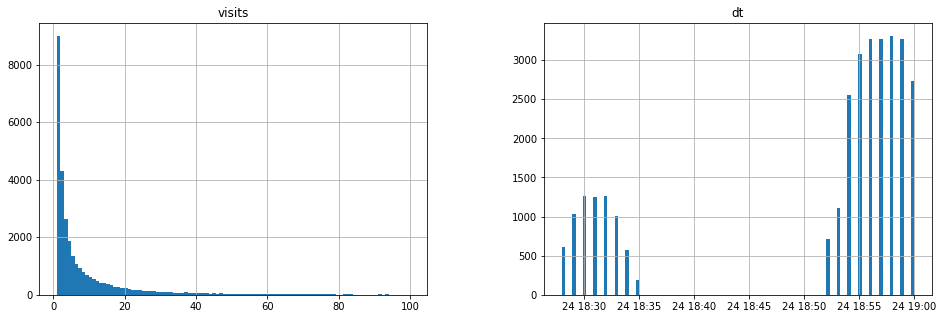

In [6]:
dash_visits.query('visits <=100').hist(column=['visits', 'dt'], bins=100, figsize=(16, 5));

Из полученной картины мы видим, что, вероятно, всё, что касается более 40 посещений можно было бы отнести к выбросам, однако, в рамках подготовки данных здесь мы ничего предпринимать не будем и продолжим работу с датасетом в Tabletau. Решение по коррекции данных будем принимать в случае, если получим очевидно неправдоподобную картину в дашборде. Из датасета уберём index, тем более, что все record_id уникальны и для дальнейшей работы он не нужен.

In [7]:
#экспортируем файл как csv
dash_visits.to_csv('dash_visits.csv', sep=',', index=False)

На основании полученных данных создан дашборд, доступный по [ссылке](https://public.tableau.com/app/profile/andrew1293/viz/Yandexdzen_16587668534750/Yandexdzen?publish=yes), а также краткая [презентация](https://disk.yandex.ru/i/b39vzbOZlhrJ9Q).